# Setup and Imports

In [1]:
# Setup
import sys
sys.path.append('../src')

from data_loader import load_sector_data, get_seasonal_returns, calculate_sector_ratio
from returns_calculator import (
    calculate_annual_returns_from_monthly,
    calculate_excess_returns,
    calculate_seasonal_returns
)
from sharpe_analysis import (
    calculate_sharpe_ratio,
    calculate_sharpe_ratio_by_season
)
from stats_analysis import calculate_statistics, seasonal_ttest
from visualization import plot_seasonal_comparison, plot_monthly_averages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✓ Setup complete!")

✓ Setup complete!


# Load data

In [2]:
# Load the data
file_path = '../data/Seasonal S&P Data as of 11.13.2025 - Abhi.xlsx'

df_disc = load_sector_data(file_path, 'Discretionary')
df_staples = load_sector_data(file_path, 'Staples')

print("Discretionary data:")
print(f"  Years: {df_disc.index.min()} - {df_disc.index.max()}")
print(f"  Shape: {df_disc.shape}")

print("\nStaples data:")
print(f"  Years: {df_staples.index.min()} - {df_staples.index.max()}")
print(f"  Shape: {df_staples.shape}")

print("\nFirst few rows of Discretionary:")
print(df_disc.head())

Discretionary data:
  Years: 1989 - 2025
  Shape: (37, 12)

Staples data:
  Years: 1989 - 2025
  Shape: (37, 12)

First few rows of Discretionary:
        Jan    Feb    Mar    Apr    May    Jun    Jul     Aug    Sep    Oct  \
Year                                                                          
1989    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN -4.817   
1990 -6.667  1.836  2.956 -3.738 10.719 -0.656 -5.683 -12.495 -8.590 -3.434   
1991  8.831  7.049  4.023  1.037  7.836 -5.655  4.187   2.347 -2.505 -1.868   
1992  2.194  4.396 -1.406  0.638 -0.190 -0.459  2.387  -2.642  2.291  2.016   
1993  3.753 -0.472  2.749 -5.877  4.262 -2.373  1.422   2.927 -0.659  7.345   

        Nov    Dec  
Year                
1989 -0.699 -0.694  
1990  9.772  2.658  
1991 -3.270 12.468  
1992  6.957  0.385  
1993  1.067 -1.368  


# Align common time period

In [3]:
# Find common years (Staples starts later than Discretionary)
common_years = df_disc.index.intersection(df_staples.index)
print(common_years)

print(f"Common time period: {common_years.min()} - {common_years.max()}")
print(f"Number of years: {len(common_years)}")

# Filter both to common period
df_disc_aligned = df_disc.loc[common_years]
df_staples_aligned = df_staples.loc[common_years]

print("\n✓ Data aligned to common period")

Index([1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025],
      dtype='int64', name='Year')
Common time period: 1989 - 2025
Number of years: 37

✓ Data aligned to common period


# Basic stats discretionary

In [6]:
# Calculate statistics for Discretionary
disc_all_returns = df_disc_aligned.values.flatten()
disc_all_returns = disc_all_returns[~np.isnan(disc_all_returns)]

print("="*70)
print("CONSUMER DISCRETIONARY - BASIC STATISTICS")
print("="*70)

disc_stats = calculate_statistics(disc_all_returns)
for key, value in disc_stats.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.3f}")
    else:
        print(f"{key:20s}: {value}")

CONSUMER DISCRETIONARY - BASIC STATISTICS
count               : 433
mean                :    0.899
median              :    0.980
std                 :    5.350
min                 :  -19.268
max                 :   20.514
skewness            :   -0.068
kurtosis            :    1.206
positive_pct        :   59.353


# Basic stats staples

In [7]:
# Calculate statistics for Staples
staples_all_returns = df_staples_aligned.values.flatten()
staples_all_returns = staples_all_returns[~np.isnan(staples_all_returns)]

print("="*70)
print("CONSUMER STAPLES - BASIC STATISTICS")
print("="*70)

staples_stats = calculate_statistics(staples_all_returns)
for key, value in staples_stats.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.3f}")
    else:
        print(f"{key:20s}: {value}")

CONSUMER STAPLES - BASIC STATISTICS
count               : 433
mean                :    0.696
median              :    0.965
std                 :    3.758
min                 :  -11.883
max                 :   15.291
skewness            :   -0.151
kurtosis            :    1.262
positive_pct        :   60.046


# Performance comparison

In [8]:
# Side-by-side comparison
print("="*70)
print("DISCRETIONARY vs STAPLES - OVERALL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Discretionary': [
        disc_stats['mean'],
        disc_stats['std'],
        disc_stats['skewness'],
        disc_stats['kurtosis'],
        disc_stats['positive_pct']
    ],
    'Staples': [
        staples_stats['mean'],
        staples_stats['std'],
        staples_stats['skewness'],
        staples_stats['kurtosis'],
        staples_stats['positive_pct']
    ]
}, index=['Mean Return (%)', 'Std Dev (%)', 
          'Skewness', 'Kurtosis', '% Positive'])

comparison_df['Difference'] = comparison_df['Discretionary'] - comparison_df['Staples']

print(comparison_df)

DISCRETIONARY vs STAPLES - OVERALL COMPARISON
                 Discretionary  Staples  Difference
Mean Return (%)          0.899    0.696       0.203
Std Dev (%)              5.350    3.758       1.592
Skewness                -0.068   -0.151       0.082
Kurtosis                 1.206    1.262      -0.057
% Positive              59.353   60.046      -0.693


# Seasonal Analysis - Discretionary

In [9]:
# Get seasonal returns for Discretionary
disc_winter = get_seasonal_returns(df_disc_aligned, 'winter')
disc_summer = get_seasonal_returns(df_disc_aligned, 'summer')

print("="*70)
print("CONSUMER DISCRETIONARY - SEASONAL ANALYSIS")
print("="*70)

print("\nWINTER (Nov-Apr):")
print(f"  Mean:           {np.mean(disc_winter):.3f}%")
print(f"  Std Dev:        {np.std(disc_winter):.3f}%")
#print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(disc_winter):.3f}")
print(f"  % Positive:     {(disc_winter > 0).sum() / len(disc_winter) * 100:.1f}%")

print("\nSUMMER (May-Oct):")
print(f"  Mean:           {np.mean(disc_summer):.3f}%")
print(f"  Std Dev:        {np.std(disc_summer):.3f}%")
#print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(disc_summer):.3f}")
print(f"  % Positive:     {(disc_summer > 0).sum() / len(disc_summer) * 100:.1f}%")

print("\nDIFFERENCE (Winter - Summer):")
print(f"  Mean diff:      {np.mean(disc_winter) - np.mean(disc_summer):.3f}%")

# T-test
disc_ttest = seasonal_ttest(disc_winter, disc_summer)
print(f"\nT-test: p-value = {disc_ttest['p_value']:.6f}")
if disc_ttest['significant_05']:
    print("✓ Seasonality is statistically significant (p < 0.05)")
else:
    print("✗ Seasonality is NOT statistically significant (p >= 0.05)")

CONSUMER DISCRETIONARY - SEASONAL ANALYSIS

WINTER (Nov-Apr):
  Mean:           1.484%
  Std Dev:        5.348%
  % Positive:     63.9%

SUMMER (May-Oct):
  Mean:           0.316%
  Std Dev:        5.275%
  % Positive:     54.8%

DIFFERENCE (Winter - Summer):
  Mean diff:      1.168%

T-test: p-value = 0.022982
✓ Seasonality is statistically significant (p < 0.05)


# Seasonal Analysis - Staples

In [10]:
# Get seasonal returns for Staples
staples_winter = get_seasonal_returns(df_staples_aligned, 'winter')
staples_summer = get_seasonal_returns(df_staples_aligned, 'summer')

print("="*70)
print("CONSUMER STAPLES - SEASONAL ANALYSIS")
print("="*70)

print("\nWINTER (Nov-Apr):")
print(f"  Mean:           {np.mean(staples_winter):.3f}%")
print(f"  Std Dev:        {np.std(staples_winter):.3f}%")
# print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(staples_winter):.3f}")
print(f"  % Positive:     {(staples_winter > 0).sum() / len(staples_winter) * 100:.1f}%")

print("\nSUMMER (May-Oct):")
print(f"  Mean:           {np.mean(staples_summer):.3f}%")
print(f"  Std Dev:        {np.std(staples_summer):.3f}%")
# print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(staples_summer):.3f}")
print(f"  % Positive:     {(staples_summer > 0).sum() / len(staples_summer) * 100:.1f}%")

print("\nDIFFERENCE (Winter - Summer):")
print(f"  Mean diff:      {np.mean(staples_winter) - np.mean(staples_summer):.3f}%")

# T-test
staples_ttest = seasonal_ttest(staples_winter, staples_summer)
print(f"\nT-test: p-value = {staples_ttest['p_value']:.6f}")
if staples_ttest['significant_05']:
    print("✓ Seasonality is statistically significant (p < 0.05)")
else:
    print("✗ Seasonality is NOT statistically significant (p >= 0.05)")

CONSUMER STAPLES - SEASONAL ANALYSIS

WINTER (Nov-Apr):
  Mean:           0.796%
  Std Dev:        3.641%
  % Positive:     63.0%

SUMMER (May-Oct):
  Mean:           0.596%
  Std Dev:        3.859%
  % Positive:     57.1%

DIFFERENCE (Winter - Summer):
  Mean diff:      0.200%

T-test: p-value = 0.580606
✗ Seasonality is NOT statistically significant (p >= 0.05)


# Visuals - Discretionary Seasonal

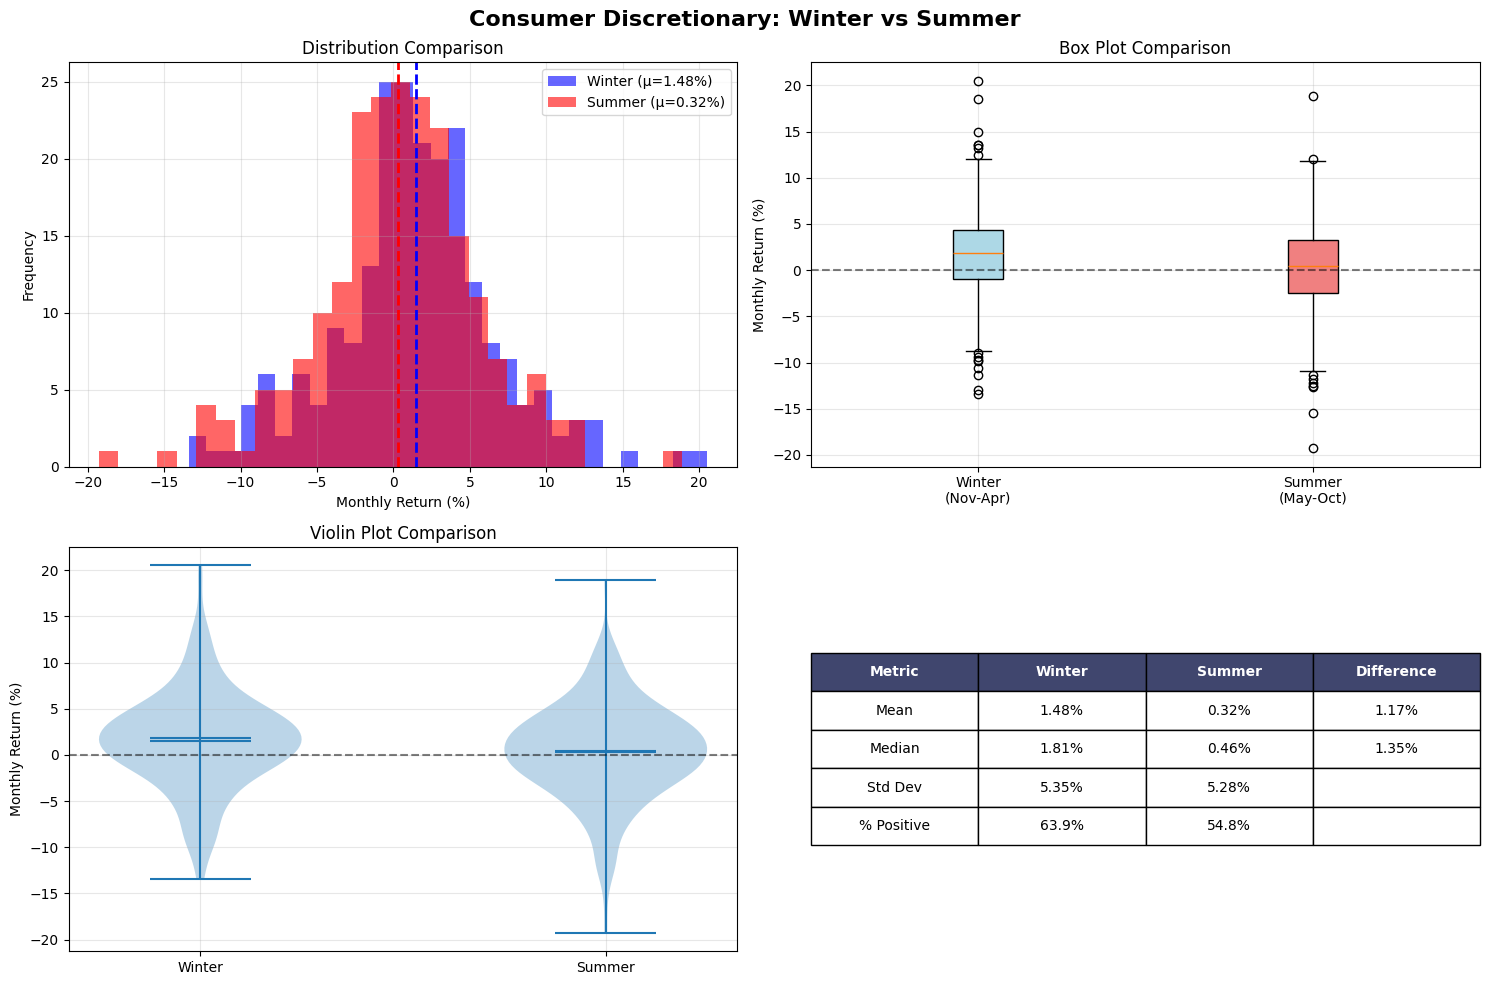

In [12]:
# Visualize Discretionary seasonal pattern
plot_seasonal_comparison(disc_winter, disc_summer, 
                        "Consumer Discretionary: Winter vs Summer")

# Visuals - Staples Seasonal

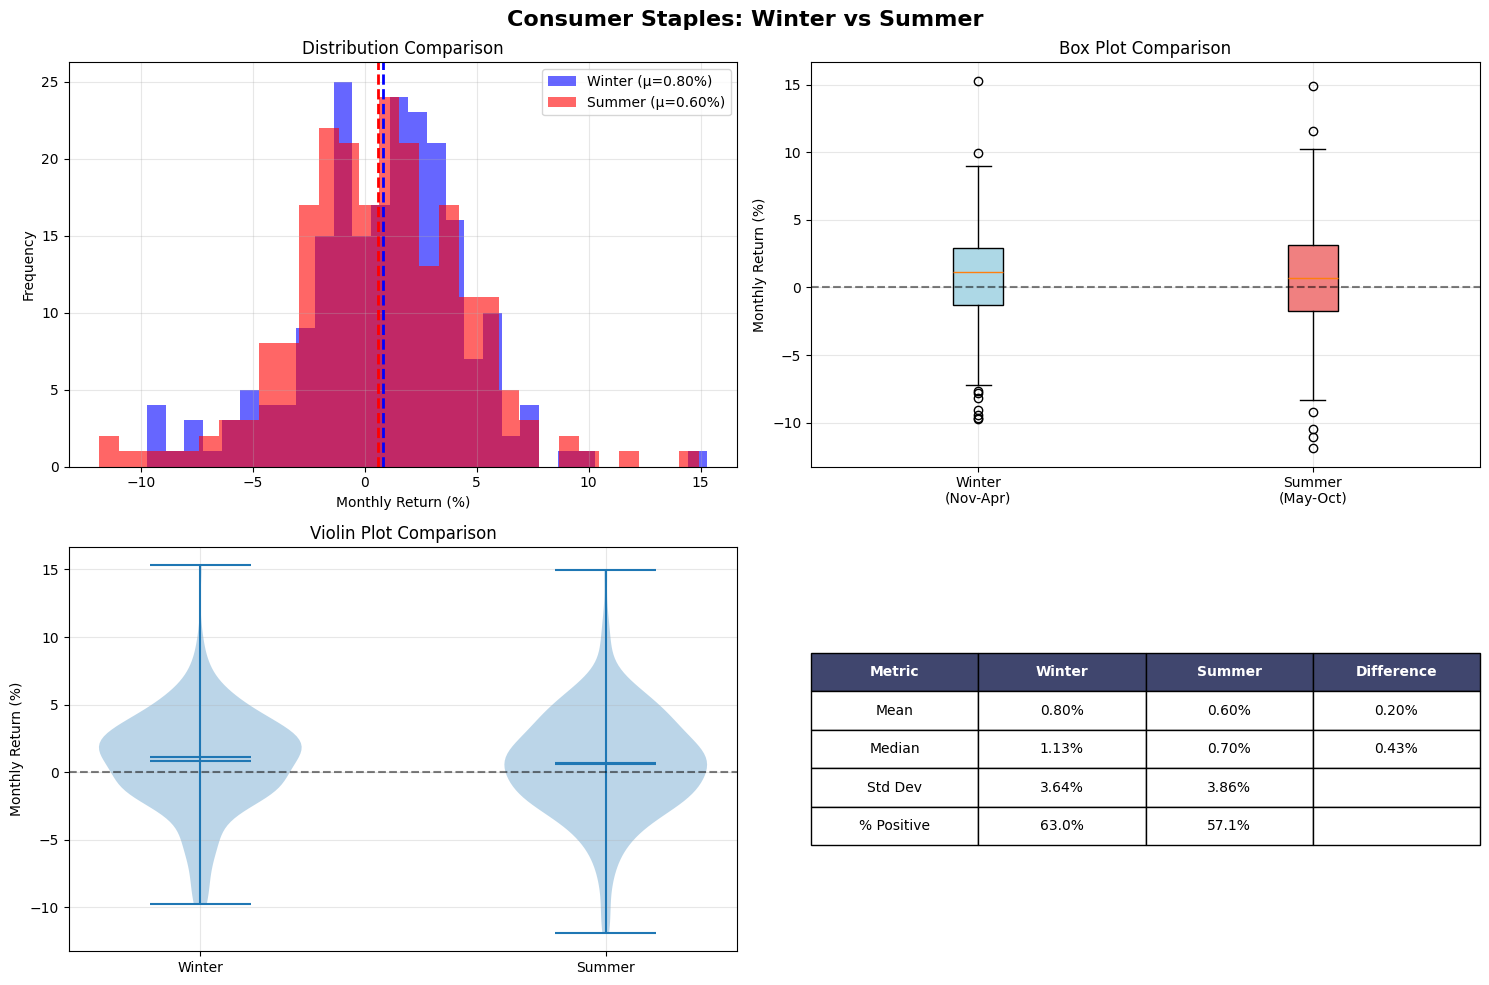

In [13]:
# Visualize Staples seasonal pattern
plot_seasonal_comparison(staples_winter, staples_summer, 
                        "Consumer Staples: Winter vs Summer")

# Discretionary / Staples Ratio

In [14]:
# Calculate the ratio (outperformance)
# Discretionary return - Staples return = offensive outperformance
df_ratio = calculate_sector_ratio(df_disc_aligned, df_staples_aligned)

print("Discretionary/Staples Ratio (Outperformance):")
print(f"Shape: {df_ratio.shape}")
print(f"\nFirst few years:")
print(df_ratio.head())

# Calculate average ratio by month
ratio_monthly_avg = df_ratio.mean()
print(f"\nAverage monthly outperformance:")
print(ratio_monthly_avg)

Discretionary/Staples Ratio (Outperformance):
Shape: (37, 12)

First few years:
       Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
Year                                                                        
1989   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN -5.190   
1990 2.959  3.416 -2.762 -4.881  0.496 -4.284 -6.687 -5.198 -4.725 -8.537   
1991 6.804 -1.904 -1.396  3.071  4.852 -0.210 -1.916 -2.756  0.965 -1.737   
1992 5.299  4.545 -0.169 -0.161 -1.207  2.424 -3.267 -3.386  0.845  2.138   
1993 6.066  0.389  2.739  3.177  2.580 -2.038  5.022 -0.714  1.956  0.534   

        Nov    Dec  
Year                
1989 -3.234 -3.464  
1990  4.558 -1.288  
1991 -3.151 -2.823  
1992  5.085  1.140  
1993  0.819 -2.143  

Average monthly outperformance:
Jan    1.932
Feb   -0.089
Mar    0.528
Apr    0.871
May   -0.203
Jun    0.270
Jul    0.300
Aug   -0.781
Sep   -0.265
Oct   -0.980
Nov    0.952
Dec   -0.065
dtype: float64


# Analyse ratio overtime

In [15]:
# Flatten ratio to analyze
ratio_all = df_ratio.values.flatten()
ratio_all = ratio_all[~np.isnan(ratio_all)]

print("="*70)
print("DISCRETIONARY/STAPLES RATIO ANALYSIS")
print("="*70)

print(f"\nMean ratio:     {np.mean(ratio_all):.3f}%")
print(f"Median ratio:   {np.median(ratio_all):.3f}%")
print(f"Std dev:        {np.std(ratio_all):.3f}%")
print(f"% Disc wins:    {(ratio_all > 0).sum() / len(ratio_all) * 100:.1f}%")

# Test if ratio is significantly different from zero
t_stat, p_val = stats.ttest_1samp(ratio_all, 0)
print(f"\nOne-sample t-test (H0: ratio = 0):")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value:     {p_val:.6f}")

if p_val < 0.05:
    if np.mean(ratio_all) > 0:
        print("✓ Discretionary significantly outperforms Staples overall")
    else:
        print("✓ Staples significantly outperforms Discretionary overall")
else:
    print("✗ No significant difference between Disc and Staples overall")

DISCRETIONARY/STAPLES RATIO ANALYSIS

Mean ratio:     0.203%
Median ratio:   0.165%
Std dev:        4.613%
% Disc wins:    52.7%

One-sample t-test (H0: ratio = 0):
  t-statistic: 0.916
  p-value:     0.360399
✗ No significant difference between Disc and Staples overall


# Ratio Seasonal Analysis

In [16]:
# Analyze ratio by season
ratio_winter = get_seasonal_returns(df_ratio, 'winter')
ratio_summer = get_seasonal_returns(df_ratio, 'summer')

print("="*70)
print("RATIO SEASONAL ANALYSIS")
print("="*70)

print("\nWINTER (Nov-Apr) - Disc Outperformance:")
print(f"  Mean:        {np.mean(ratio_winter):.3f}%")
print(f"  % Disc wins: {(ratio_winter > 0).sum() / len(ratio_winter) * 100:.1f}%")

print("\nSUMMER (May-Oct) - Disc Outperformance:")
print(f"  Mean:        {np.mean(ratio_summer):.3f}%")
print(f"  % Disc wins: {(ratio_summer > 0).sum() / len(ratio_summer) * 100:.1f}%")

print("\nDIFFERENCE:")
print(f"  Disc outperforms more in: {'Winter' if np.mean(ratio_winter) > np.mean(ratio_summer) else 'Summer'}")
print(f"  Difference: {np.mean(ratio_winter) - np.mean(ratio_summer):.3f}%")

# T-test
ratio_seasonal_test = seasonal_ttest(ratio_winter, ratio_summer)
print(f"\nT-test p-value: {ratio_seasonal_test['p_value']:.6f}")

RATIO SEASONAL ANALYSIS

WINTER (Nov-Apr) - Disc Outperformance:
  Mean:        0.688%
  % Disc wins: 56.9%

SUMMER (May-Oct) - Disc Outperformance:
  Mean:        -0.280%
  % Disc wins: 48.4%

DIFFERENCE:
  Disc outperforms more in: Winter
  Difference: 0.968%

T-test p-value: 0.029080


# Visualize ratio distributions

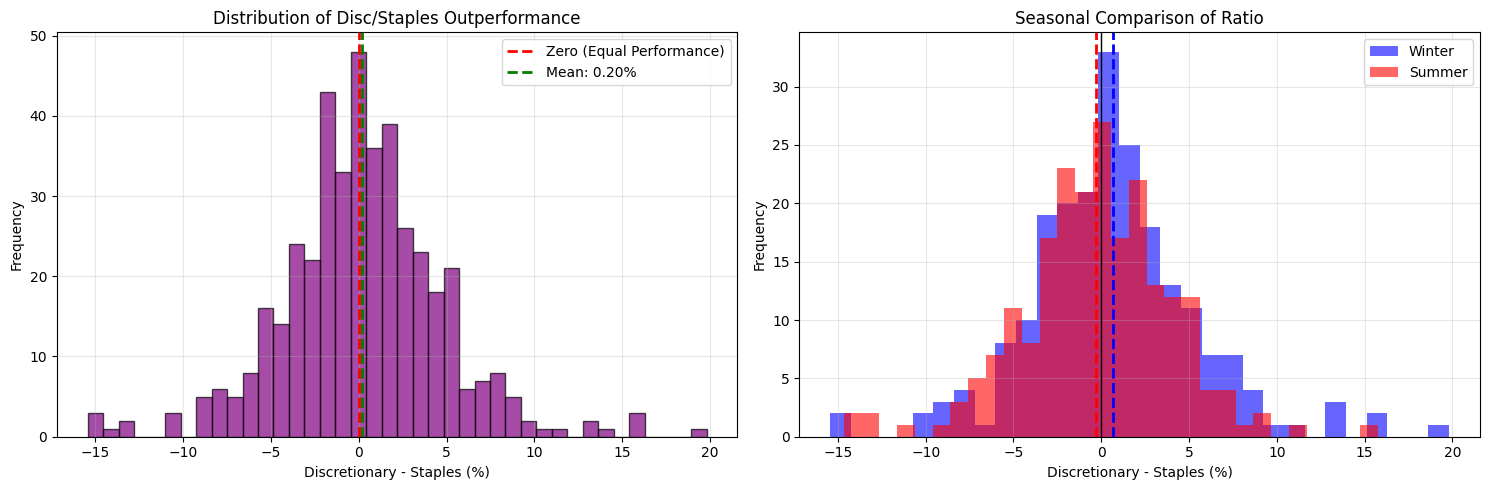

In [17]:
# Visualize the ratio distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(ratio_all, bins=40, edgecolor='black', alpha=0.7, color='purple')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (Equal Performance)')
axes[0].axvline(np.mean(ratio_all), color='green', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(ratio_all):.2f}%')
axes[0].set_xlabel('Discretionary - Staples (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Disc/Staples Outperformance')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Seasonal comparison
axes[1].hist(ratio_winter, bins=30, alpha=0.6, label='Winter', color='blue')
axes[1].hist(ratio_summer, bins=30, alpha=0.6, label='Summer', color='red')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].axvline(np.mean(ratio_winter), color='blue', linestyle='--', linewidth=2)
axes[1].axvline(np.mean(ratio_summer), color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Discretionary - Staples (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Seasonal Comparison of Ratio')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Time series of ratio: 

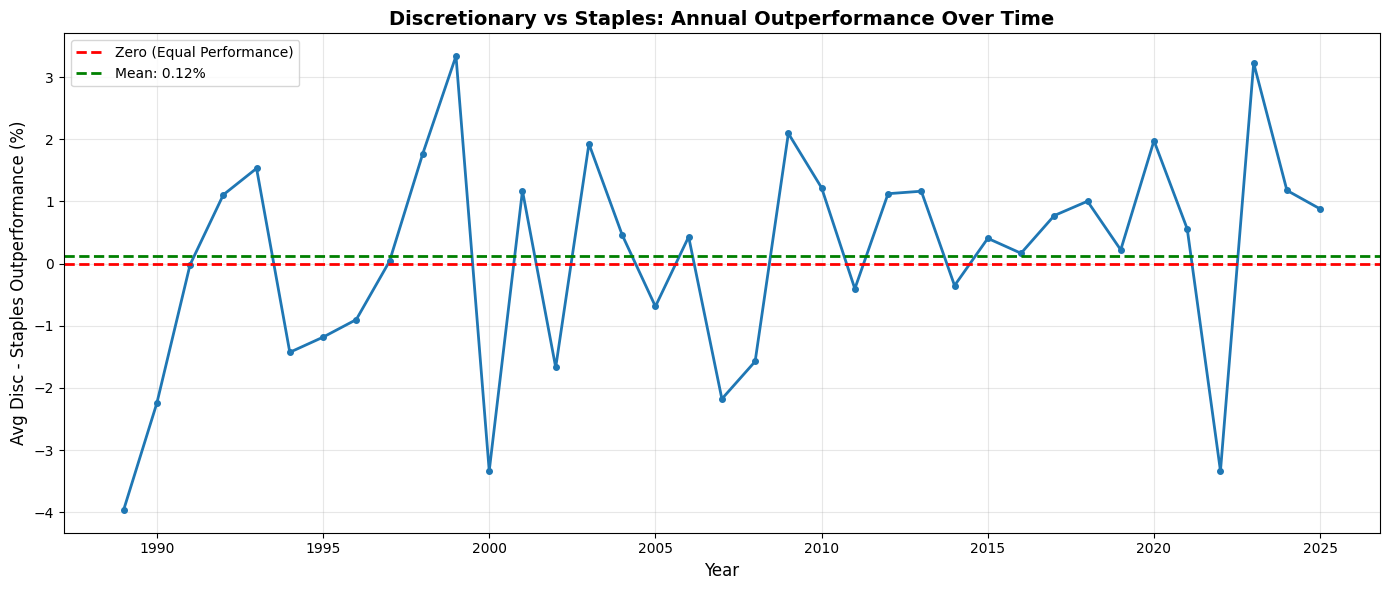

Trend analysis:
  1990s avg: -0.177%
  2000s avg: -0.335%
  2010s avg: 0.532%
  2020s avg: 0.747%


In [18]:
# Plot ratio over time (annual average)
annual_ratio = df_ratio.mean(axis=1)  # Average across all months per year

plt.figure(figsize=(14, 6))
plt.plot(annual_ratio.index, annual_ratio.values, marker='o', linewidth=2, markersize=4)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero (Equal Performance)')
plt.axhline(np.mean(annual_ratio), color='green', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(annual_ratio):.2f}%')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg Disc - Staples Outperformance (%)', fontsize=12)
plt.title('Discretionary vs Staples: Annual Outperformance Over Time', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Trend analysis:")
print(f"  1990s avg: {annual_ratio[annual_ratio.index < 2000].mean():.3f}%")
print(f"  2000s avg: {annual_ratio[(annual_ratio.index >= 2000) & (annual_ratio.index < 2010)].mean():.3f}%")
print(f"  2010s avg: {annual_ratio[(annual_ratio.index >= 2010) & (annual_ratio.index < 2020)].mean():.3f}%")
print(f"  2020s avg: {annual_ratio[annual_ratio.index >= 2020].mean():.3f}%")

# Heatmap of ratios

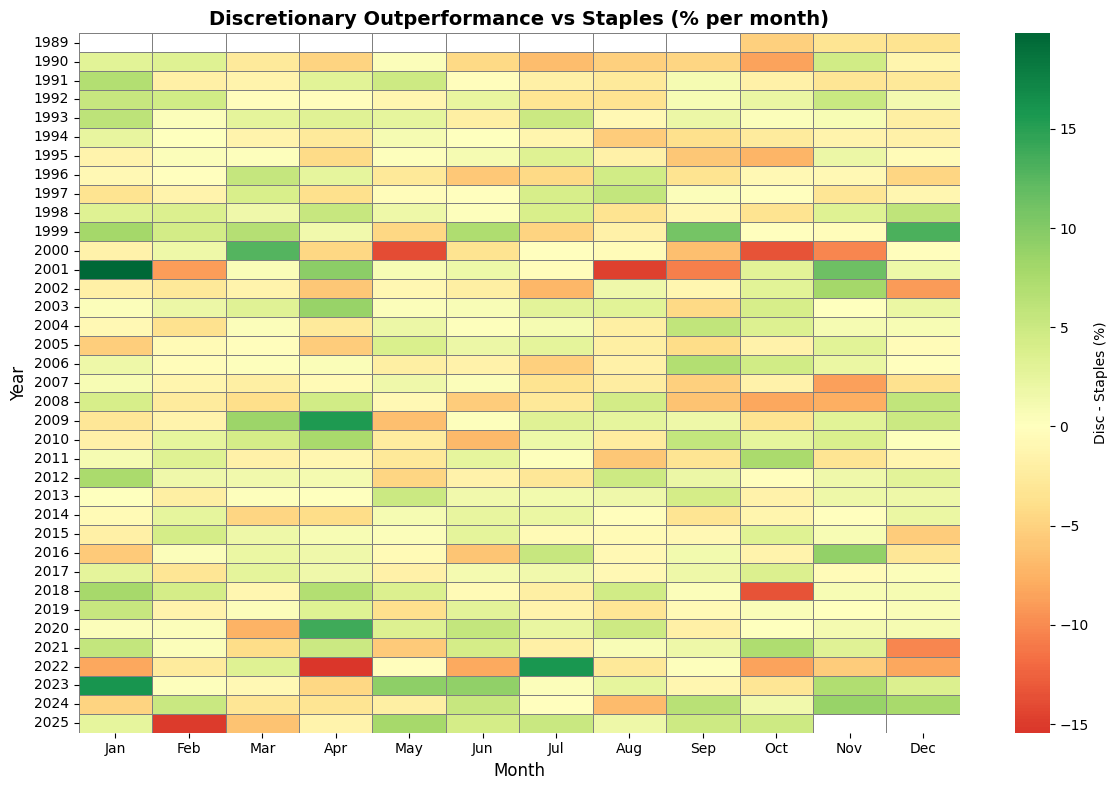

In [19]:
# Create heatmap showing which months Disc outperforms
plt.figure(figsize=(12, 8))
sns.heatmap(df_ratio, cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Disc - Staples (%)'},
            linewidths=0.5, linecolor='gray')
plt.title('Discretionary Outperformance vs Staples (% per month)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

# Sharpe ratio analysis

In [3]:
df_tbills = load_sector_data(file_path, 'TBills')
# Load tbill data
print("Loading data...")
print(df_tbills.head())

Loading data...
       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
Year                                                                        
2001   NaN   NaN   NaN   NaN   NaN   NaN   NaN 3.480 2.630 2.240 1.960 1.690
2002 1.650 1.700 1.750 1.690 1.710 1.680 1.690 1.660 1.650 1.600 1.240 1.180
2003 1.150 1.180 1.160 1.140 1.060 0.960 0.880 0.930 0.890 0.890 0.920 0.870
2004 0.830 0.900 0.950 0.890 0.890 1.020 1.160 1.350 1.520 1.600 1.880 1.920
2005 1.990 2.320 2.600 2.590 2.590 2.780 3.040 3.280 3.160 3.440 3.840 3.610


## align data to common years

In [4]:
# Find common years across all three datasets
common_years = (df_disc.index
                .intersection(df_staples.index)
                .intersection(df_tbills.index))

# Align all data
df_disc_aligned = df_disc.loc[common_years]
df_staples_aligned = df_staples.loc[common_years]
df_rf_aligned = df_tbills.loc[common_years]

print("="*70)
print("ALIGNED DATA")
print("="*70)
print(f"Common period: {common_years.min()} to {common_years.max()}")
print(f"Number of years: {len(common_years)}")
print(f"Total months: {len(common_years) * 12}")

print("\nSample (year 2020):")
print("\nDiscretionary:")
print(df_disc_aligned.loc[2020])
print("\nStaples:")
print(df_staples_aligned.loc[2020])
print("\nRisk-Free Rate (monthly):")
print(df_rf_aligned.loc[2020])

ALIGNED DATA
Common period: 2001 to 2025
Number of years: 25
Total months: 300

Sample (year 2020):

Discretionary:
Jan     0.580
Feb    -7.686
Mar   -13.394
Apr    20.514
May     4.863
Jun     4.902
Jul     8.978
Aug     9.435
Sep    -3.686
Oct    -2.953
Nov     8.481
Dec     2.449
Name: 2020, dtype: float64

Staples:
Jan    0.198
Feb   -8.182
Mar   -5.860
Apr    6.644
May    1.376
Jun   -0.735
Jul    6.765
Aug    4.598
Sep   -1.845
Oct   -2.986
Nov    7.336
Dec    1.450
Name: 2020, dtype: float64

Risk-Free Rate (monthly):
Jan   1.500
Feb   1.550
Mar   0.360
Apr   0.110
May   0.100
Jun   0.130
Jul   0.110
Aug   0.080
Sep   0.090
Oct   0.090
Nov   0.090
Dec   0.080
Name: 2020, dtype: float64


## Calculating excess returns

In [5]:
# Calculate annual returns (excess of risk-free)
print("Calculating annual returns...")

annual_disc = calculate_annual_returns_from_monthly(df_disc_aligned, df_rf_aligned)
annual_stap = calculate_annual_returns_from_monthly(df_staples_aligned, df_rf_aligned)

# Clean any NaN years
annual_disc_clean = annual_disc.dropna()
annual_stap_clean = annual_stap.dropna()

print("="*70)
print("ANNUAL EXCESS RETURNS")
print("="*70)

print(f"\nConsumer Discretionary:")
print(f"  Sample size:     {len(annual_disc_clean)} years")
print(f"  Mean:            {annual_disc_clean.mean():.2f}%")
print(f"  Median:          {annual_disc_clean.median():.2f}%")
print(f"  Std deviation:   {annual_disc_clean.std(ddof=1):.2f}%")
print(f"  Min:             {annual_disc_clean.min():.2f}%")
print(f"  Max:             {annual_disc_clean.max():.2f}%")

print(f"\nConsumer Staples:")
print(f"  Sample size:     {len(annual_stap_clean)} years")
print(f"  Mean:            {annual_stap_clean.mean():.2f}%")
print(f"  Median:          {annual_stap_clean.median():.2f}%")
print(f"  Std deviation:   {annual_stap_clean.std(ddof=1):.2f}%")
print(f"  Min:             {annual_stap_clean.min():.2f}%")
print(f"  Max:             {annual_stap_clean.max():.2f}%")

print(f"\n" + "="*70)
print("COMPARISON:")
print(f"  Mean difference:     {annual_disc_clean.mean() - annual_stap_clean.mean():.2f}%")
print(f"  Volatility ratio:    {annual_disc_clean.std(ddof=1) / annual_stap_clean.std(ddof=1):.2f}x")

Calculating annual returns...
year, return risk free, and excess: 2001 2.3999999999999995 -0.004508976079523136
year, return risk free, and excess: 2002 1.5999999999999996 -0.26045100424967893
year, return risk free, and excess: 2003 1.0025000000000002 0.3508505129958965
year, return risk free, and excess: 2004 1.2425 0.10900644350623226
year, return risk free, and excess: 2005 2.936666666666667 -0.10290556949922315
year, return risk free, and excess: 2006 4.659166666666667 0.12574472406052908
year, return risk free, and excess: 2007 4.310833333333334 -0.18634747237994656
year, return risk free, and excess: 2008 1.265 -0.3399394773224493
year, return risk free, and excess: 2009 0.09583333333333334 0.3866220928516611
year, return risk free, and excess: 2010 0.1125 0.2561047613476833
year, return risk free, and excess: 2011 0.03833333333333333 0.043748873463108254
year, return risk free, and excess: 2012 0.07 0.2206107270446466
year, return risk free, and excess: 2013 0.04750000000000001

## Calculate Sharpe Ratios: 

In [7]:
# Calculate Sharpe ratios on ANNUAL data
sharpe_disc = calculate_sharpe_ratio(annual_disc_clean, frequency='annual')
sharpe_stap = calculate_sharpe_ratio(annual_stap_clean, frequency='annual')

print("="*70)
print("SHARPE RATIOS (Annualized, using Annual Data)")
print("="*70)

print(f"\nConsumer Discretionary:")
print(f"  Annualized Excess Return:   {annual_disc_clean.mean():.2f}%")
print(f"  Annualized Vol:      {annual_disc_clean.std(ddof=1):.2f}%")
print(f"  Sharpe Ratio:        {sharpe_disc:.3f}")

print(f"\nConsumer Staples:")
print(f"  Annualized Excess Return:   {annual_stap_clean.mean():.2f}%")
print(f"  Annualized Vol:      {annual_stap_clean.std(ddof=1):.2f}%")
print(f"  Sharpe Ratio:        {sharpe_stap:.3f}")

print(f"\n" + "="*70)
print("WINNER:")
print("="*70)
if sharpe_disc > sharpe_stap:
    print(f"✓ Discretionary has superior risk-adjusted returns")
    print(f"  Sharpe advantage: {sharpe_disc - sharpe_stap:.3f}")
    print(f"  ({(sharpe_disc - sharpe_stap) / sharpe_stap * 100:.1f}% higher)")
else:
    print(f"✓ Staples has superior risk-adjusted returns")
    print(f"  Sharpe advantage: {sharpe_stap - sharpe_disc:.3f}")
    print(f"  ({(sharpe_stap - sharpe_disc) / sharpe_disc * 100:.1f}% higher)")

print("\nBenchmark interpretation:")
print("  SR > 0.5  = Decent")
print("  SR > 1.0  = Good")
print("  SR > 2.0  = Excellent")

SHARPE RATIOS (Annualized, using Annual Data)

Consumer Discretionary:
  Annualized Excess Return:   9.69%
  Annualized Vol:      22.24%
  Sharpe Ratio:        0.436

Consumer Staples:
  Annualized Excess Return:   4.12%
  Annualized Vol:      10.27%
  Sharpe Ratio:        0.401

WINNER:
✓ Discretionary has superior risk-adjusted returns
  Sharpe advantage: 0.035
  (8.7% higher)

Benchmark interpretation:
  SR > 0.5  = Decent
  SR > 1.0  = Good
  SR > 2.0  = Excellent
